In [26]:
import pandas as pd

train_data = pd.read_csv('data/train.csv')
train_data.shape

(3000888, 6)

In [30]:
train_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [42]:
def cap_sales(df):
    df.sales = df.sales.map(lambda x: x if x < 20000 else 20000)
    return df

train_data = cap_sales(train_data)

<Axes: >

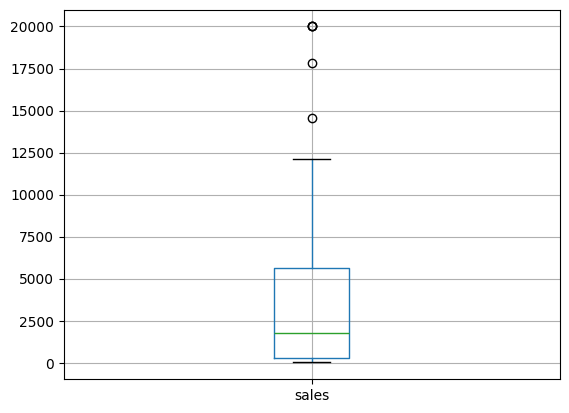

In [43]:
train_data.groupby('family')[['sales']].max().boxplot()

In [2]:
stores_df = pd.read_csv('data/stores.csv')
stores_df_transformed = stores_df.drop(['city', 'state', 'type'], axis=1)
merged_store_train = pd.merge(train_data, stores_df_transformed, on=['store_nbr','store_nbr'])
merged_store_train = merged_store_train.drop(['store_nbr'], axis=1)

In [3]:
print(merged_store_train.shape)
merged_store_train.head()

(3000888, 6)


,id,date,family,sales,onpromotion,cluster
0,0,2013-01-01,AUTOMOTIVE,0.0,0,13
1,1,2013-01-01,BABY CARE,0.0,0,13
2,2,2013-01-01,BEAUTY,0.0,0,13
3,3,2013-01-01,BEVERAGES,0.0,0,13
4,4,2013-01-01,BOOKS,0.0,0,13


In [4]:
holidays_df = pd.read_csv('data/holidays_events.csv')

mask = holidays_df['transferred'].apply(lambda x: x is False)
holidays_filtered = holidays_df[mask].copy()
holidays_filtered['is_holiday'] = True
holidays_filtered = holidays_filtered.drop(['type', 'locale', 'locale_name', 'description', 'transferred'], axis=1)
print(holidays_filtered.shape)
holidays_filtered.head()

(338, 2)


,date,is_holiday
0,2012-03-02,True
1,2012-04-01,True
2,2012-04-12,True
3,2012-04-14,True
4,2012-04-21,True


In [5]:
holidays_filtered.loc[holidays_filtered['date'] == '2017-12-22']

,date,is_holiday
344,2017-12-22,True
345,2017-12-22,True


In [6]:
holidays_filtered = holidays_filtered.drop_duplicates()

In [7]:
print(merged_store_train.shape)
merged_store_holiday_train = pd.merge(merged_store_train, holidays_filtered, on=['date', 'date'], how='left')

(3000888, 6)


In [8]:
print(merged_store_holiday_train.shape)
merged_store_holiday_train.is_holiday = merged_store_holiday_train.is_holiday.fillna(False)
print(merged_store_holiday_train.shape)

(3000888, 7)
(3000888, 7)


In [9]:
oil_df = pd.read_csv('data/oil.csv')
oil_df.columns

Index(['date', 'dcoilwtico'], dtype='object')

In [10]:
filled_oil_df = oil_df.copy()
filled_oil_df['oil_price'] = oil_df.dcoilwtico.ffill().bfill()

In [11]:
filled_oil_df = filled_oil_df.drop(['dcoilwtico'], axis=1)

In [12]:
print(merged_store_holiday_train.columns)
print(merged_store_holiday_train.shape)

Index(['id', 'date', 'family', 'sales', 'onpromotion', 'cluster',
       'is_holiday'],
      dtype='object')
(3000888, 7)


In [13]:
final_merged_df = pd.merge(merged_store_holiday_train, filled_oil_df, on=['date', 'date'], how='left')
final_merged_df = final_merged_df.bfill()

In [14]:
final_merged_df.shape

(3000888, 8)

In [15]:
final_merged_df.head()

,id,date,family,sales,onpromotion,cluster,is_holiday,oil_price
0,0,2013-01-01,AUTOMOTIVE,0.0,0,13,True,93.14
1,1,2013-01-01,BABY CARE,0.0,0,13,True,93.14
2,2,2013-01-01,BEAUTY,0.0,0,13,True,93.14
3,3,2013-01-01,BEVERAGES,0.0,0,13,True,93.14
4,4,2013-01-01,BOOKS,0.0,0,13,True,93.14


In [15]:
df_with_dummies = pd.get_dummies(final_merged_df, columns=['family'])

In [16]:
df_with_dummies.head()

,id,date,sales,onpromotion,cluster,is_holiday,oil_price,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,0,2013-01-01,0.0,0,13,True,93.14,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,2013-01-01,0.0,0,13,True,93.14,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,2,2013-01-01,0.0,0,13,True,93.14,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,3,2013-01-01,0.0,0,13,True,93.14,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,2013-01-01,0.0,0,13,True,93.14,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
df_with_dummies.shape

(3000888, 40)

In [18]:
df_with_dummies['day_of_week'] = pd.to_datetime(df_with_dummies['date']).dt.dayofweek

<Axes: xlabel='day_of_week'>

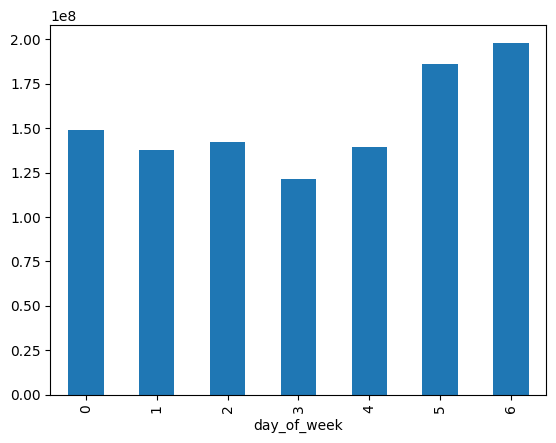

In [19]:
df_with_dummies.groupby('day_of_week')['sales'].sum().plot(kind='bar')

Conclusion: Clearly weekend days have higher sales than week days

In [20]:
df_with_dummies['is_weekend'] = df_with_dummies['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [21]:
df_with_dummies['month'] = pd.to_datetime(df_with_dummies['date']).dt.month

In [22]:
df_with_dummies['date'] = pd.to_datetime(df_with_dummies['date'])
df_with_dummies['encoded_date'] = (df_with_dummies['date'] - df_with_dummies['date'].min()).dt.days + 1

In [23]:
df_with_dummies.columns

Index(['id', 'date', 'sales', 'onpromotion', 'cluster', 'is_holiday',
       'oil_price', 'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'day_of_week',
       'is_weekend', 'month', 'encoded_date'],
      dtype='object')

In [24]:
df_with_dummies.shape

(3000888, 44)